In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 26 22:03:18 2021

@author: pmarc
Résolution Problème L14 - #2 par Pierre-Marc Juneau, 24 novembre 2022
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
import statsmodels.api as sm
import scipy.stats as sts
import math


In [2]:

donnee = pd.read_csv('../Fichiers/irisv0r1.csv')
stats=donnee.describe()
dimensions=donnee.shape
nomsvariables = pd.DataFrame(donnee.columns)



In [12]:

"Matrice de corrélation"

donnee_num=pd.get_dummies(donnee)
MatriceR=donnee_num.corr()

"Définition des matrices"

X=donnee.drop({'Espèces'}, 1)
#Y=pd.get_dummies(donnee['Espèces'])
Y=pd.get_dummies(donnee['Espèces'], drop_first=True)



/tmp/ipykernel_177085/2552785082.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


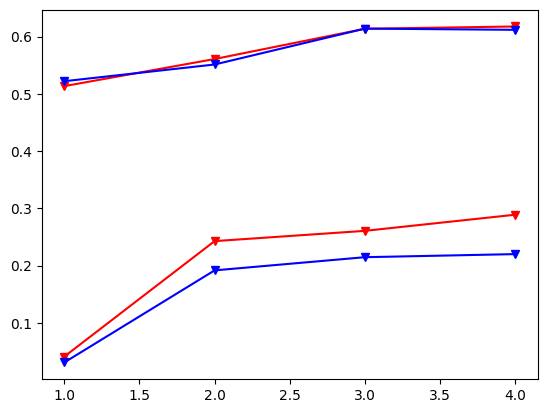

In [13]:

"Déterminer le nombre de composantes principales pour PLS-DA"

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.5,random_state=50)

R2_global =[]
Q2_global =[]
for i in np.arange(1,X.shape[1]+1):
    pls_model = PLSRegression(n_components=i).fit(X_train,Y_train)
    Y_chap_train=pls_model.predict(X_train)
    Y_chap_train=pd.DataFrame(Y_chap_train)
    Y_chap_train.columns=Y_train.columns
    R2=r2_score(Y_train,Y_chap_train,multioutput='raw_values')
    R2_global.append(R2)
    Y_chap_test=pls_model.predict(X_test)
    Y_chap_test=pd.DataFrame(Y_chap_test)
    Y_chap_test.columns=Y_test.columns
    Q2=r2_score(Y_test,Y_chap_test,multioutput='raw_values')
    Q2_global.append(Q2)
    

R2_global=pd.DataFrame(R2_global)
R2_global.columns=Y_test.columns
Q2_global=pd.DataFrame(Q2_global)
Q2_global.columns=Y_test.columns        
ax=plt.plot(np.arange(1,X.shape[1]+1),np.array(R2_global),"-v",c="r");
ax=plt.plot(np.arange(1,X.shape[1]+1),np.array(Q2_global),"-v",c="b");


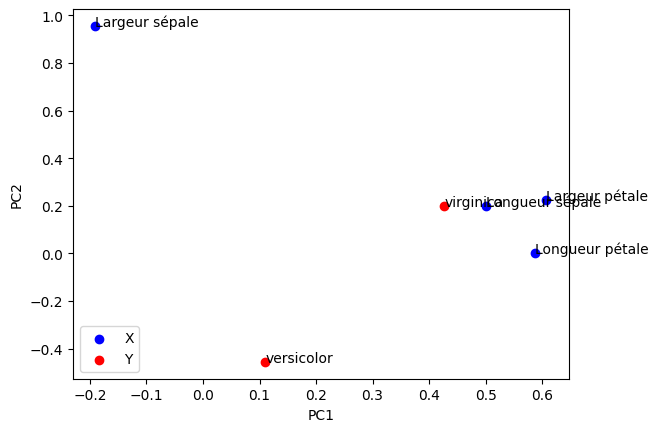

In [14]:


"Choix"
a=2
pls_model = PLSRegression(n_components=a).fit(X,Y)
Y_chap=pls_model.predict(X)
Y_chap=pd.DataFrame(Y_chap)

"Loadings bi-plot"
Def_columns=[]
for i in range(a):
    Def_columns.append('PC'+str(i+1))
Def_columns.append('Tag')

W=pls_model.x_weights_
P=pls_model.x_loadings_
W_s=np.dot(W,np.linalg.inv(np.dot(P.T,W)))
X_loadings=pd.DataFrame(W_s)
X_loadings=pd.concat([X_loadings,pd.DataFrame(X.columns)],axis=1)
X_loadings.index=X.columns
X_loadings.columns=Def_columns

Y_loadings=pd.DataFrame(pls_model.y_weights_)
Y_loadings=pd.concat([Y_loadings,pd.DataFrame(Y.columns)],axis=1)
Y_loadings.index=Y.columns
Y_loadings.columns=Def_columns


PLS_Loadings=pd.concat([X_loadings,Y_loadings],axis=0)

fig, ax = plt.subplots()
ax.scatter(X_loadings['PC1'], X_loadings['PC2'],color='blue',label='X')
ax.scatter(Y_loadings['PC1'], Y_loadings['PC2'],color='red',label='Y')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#ax.set_xlim([-0.5,0.5])
#ax.set_ylim([-0.5,0.5])


for i, txt in enumerate(PLS_Loadings['Tag']):
    ax.annotate(txt, (PLS_Loadings['PC1'][i], PLS_Loadings['PC2'][i]))
ax=plt.legend(loc='lower left')


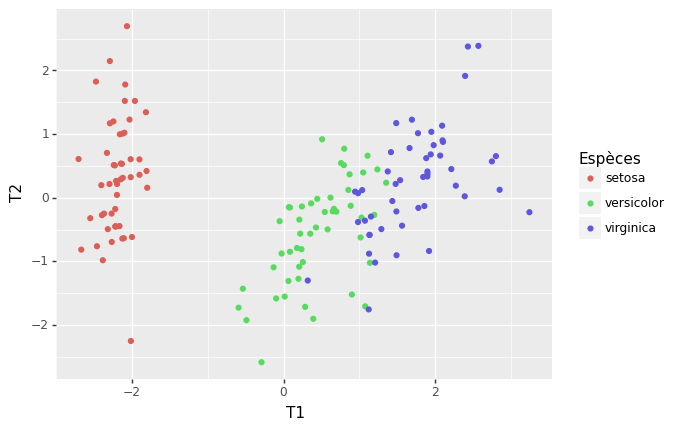

In [15]:


"Scores plot"

T = pls_model.x_scores_
W = pls_model.x_weights_
Q = pls_model.y_loadings_

Def_columns2=[]
for i in range(a):
    Def_columns2.append('T'+str(i+1))

TPanda=pd.DataFrame(T)
TPanda.index=X.index
TPanda.columns=Def_columns2
Yclass=donnee['Espèces']
T_resultats=pd.concat([TPanda,Yclass],axis=1)

import plotnine as p9
graph = p9.ggplot(data=T_resultats,
           mapping=p9.aes(x='T1', y='T2', color='Espèces'))
print(graph + p9.geom_point())

"Calcul des VIP"
#Code proposé de https://github.com/scikit-learn/scikit-learn/issues/7050

p, h = W.shape
VIPs = np.zeros((p,))
s = np.diag(T.T @ T @ Q.T @ Q).reshape(h, -1)
total_s = np.sum(s)
for i in range(p):
    weight = np.array([ (W[i,j] / np.linalg.norm(W[:,j]))**2 for j in range(h) ])
    VIPs[i] = np.sqrt(p*(s.T @ weight)/total_s)
VIP_Panda=pd.DataFrame(VIPs)
VIP_Panda.index=X.columns
VIP_Panda.columns=["VIP"]




